In [28]:
# Imports
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt 

In [2]:
# Hyperparmeters
batch_size = 128
learning_rate = 0.001

# Other constants
input_size = 28*28
num_classes = 10

In [3]:
# Download dataset
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)

# Training validation & test dataset
train_ds, val_ds = random_split(dataset, [50000, 10000])
test_ds = MNIST(root='data/', train=False, transform=transforms.ToTensor())

# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

100.1%

Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw


113.5%

Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw


100.4%

Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw


180.4%

Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw
Processing...
Done!


..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Label: 2


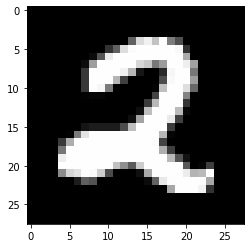

In [6]:
image, label = train_ds[6]
plt.imshow(image[0], cmap='gray')
print('Label:', label)

In [7]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

In [8]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [9]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [10]:
evaluate(model, val_loader)

{'val_loss': 2.350123882293701, 'val_acc': 0.10029296576976776}

In [17]:
history = fit(50, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1227, val_acc: 0.8103
Epoch [1], val_loss: 1.0480, val_acc: 0.8168
Epoch [2], val_loss: 0.9870, val_acc: 0.8216
Epoch [3], val_loss: 0.9364, val_acc: 0.8257
Epoch [4], val_loss: 0.8936, val_acc: 0.8290
Epoch [5], val_loss: 0.8571, val_acc: 0.8319
Epoch [6], val_loss: 0.8254, val_acc: 0.8344
Epoch [7], val_loss: 0.7977, val_acc: 0.8378
Epoch [8], val_loss: 0.7733, val_acc: 0.8395
Epoch [9], val_loss: 0.7515, val_acc: 0.8418
Epoch [10], val_loss: 0.7320, val_acc: 0.8439
Epoch [11], val_loss: 0.7144, val_acc: 0.8465
Epoch [12], val_loss: 0.6984, val_acc: 0.8487
Epoch [13], val_loss: 0.6838, val_acc: 0.8509
Epoch [14], val_loss: 0.6705, val_acc: 0.8524
Epoch [15], val_loss: 0.6582, val_acc: 0.8535
Epoch [16], val_loss: 0.6468, val_acc: 0.8546
Epoch [17], val_loss: 0.6362, val_acc: 0.8564
Epoch [18], val_loss: 0.6264, val_acc: 0.8580
Epoch [19], val_loss: 0.6172, val_acc: 0.8584
Epoch [20], val_loss: 0.6087, val_acc: 0.8590
Epoch [21], val_loss: 0.6007, val_acc: 0.859

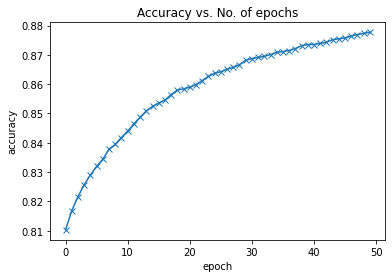

In [18]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [19]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_loss': 0.4545547366142273, 'val_acc': 0.8861328363418579}

In [20]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 5 , Predicted: 5


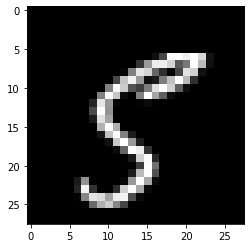

In [25]:
img, label = test_ds[211]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [57]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()/1000
    
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

Predicted Digit = 7


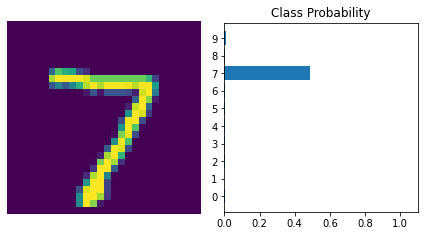

In [67]:
%matplotlib inline
def make_prediction(data):
    images, labels = next(iter(data))

    img = images[0].view(1, 784)
    
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img)
                
    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    
    probab = list(ps.numpy()[0])
    print("Predicted Digit =", probab.index(max(probab)))
    
    view_classify(img.view(1, 28, 28), ps)
    
make_prediction(test_loader)

In [65]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

In [68]:
correct_count, all_count = 0, 0

for images,labels in test_loader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = model(img)

    
        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        
        if(true_label == pred_label):
            correct_count += 1
            all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 8879

Model Accuracy = 1.0
